### Predicting customer loan eligibility Using a Pipeline and a DecisionTreeClassifier

Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban and rural areas. Customer first applies for home loan and after that company validates the customer eligibility for loan.

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers.

In [370]:
import numpy as np
import pandas as pd

loan_data = pd.read_csv('loan_data_set.csv')
print(loan_data.shape)
loan_data.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Handling Missing Values

In [371]:
#Explore the data for missing values
loan_data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [372]:
#Drop 13 rows with missing values in the gender column
loan_data1 = loan_data[loan_data['Gender'].notna()]
print(loan_data1.shape)
loan_data1.isnull().sum()

(601, 13)


Loan_ID               0
Gender                0
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       49
Property_Area         0
Loan_Status           0
dtype: int64

In [373]:
#Fill missing values in 'Married' column with 'Yes' if loan value is equal or greater than $153 and 'No' otherwise
m = loan_data1['Married'].isna()
loan_data1.loc[m, 'Married'] = np.where(loan_data1.loc[m, 'LoanAmount']>=153, 'Yes', 'No')

loan_data1.isnull().sum()

c:\users\elijah\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Loan_ID               0
Gender                0
Married               0
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       49
Property_Area         0
Loan_Status           0
dtype: int64

In [374]:
#Fill missing values in the numerical columns with the respective column means 
loan_data2 = loan_data1.fillna(loan_data1.mean())

#drop the remaining rows with missing values
loan_data2 = loan_data2.dropna()

#drop the loan_ID column
loan_data3 = loan_data2.drop('Loan_ID', axis=1)

print(loan_data3.shape)
loan_data3.isnull().sum()

(554, 12)


Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Data Preprocessing

In [375]:
from sklearn.preprocessing import LabelEncoder

#Do label encoding to the 'Dependents' categorical column(ordinal) and drop the old column
label_enc = LabelEncoder()
loan_data3['Dependents1'] = label_enc.fit_transform(loan_data3['Dependents'])
loan_data4 = loan_data3.drop('Dependents', axis=1)

#Split the data into X and y. Label encode y into a binary classification
X = loan_data4.drop('Loan_Status', axis=1)
y = loan_data4['Loan_Status']
y = label_enc.fit_transform(y)

#Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [376]:
#Create a column transformer to one-hot encode all other categorical features without affecting the rest
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
col_trans = make_column_transformer((OneHotEncoder(drop='first', sparse=False),categorical_columns), remainder='passthrough')

In [377]:
#Create a pipeline to preprocess(as above) the data then fit a classification model
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

svc_model = DecisionTreeClassifier(max_depth=3, min_samples_leaf = 30)
pipe = make_pipeline(col_trans, svc_model)

pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['Gender', 'Married',
                                                   'Education', 'Self_Employed',
                                                   'Property_Area'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=3, min_samples_leaf=30))])

In [378]:
#Since it is a classification task, we shall evaluate the model using the F1 Score and confusion matrix 
from sklearn.metrics import f1_score, confusion_matrix

y_pred = pipe.predict(X_test)

print(f'F1-Score {round(f1_score(y_test, y_pred)*100,3)} %\n')
print('Confusion Matrix')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

F1-Score 87.006 %

Confusion Matrix


Predicted,0,1,All
True,,,
0,11,22,33
1,1,77,78
All,12,99,111


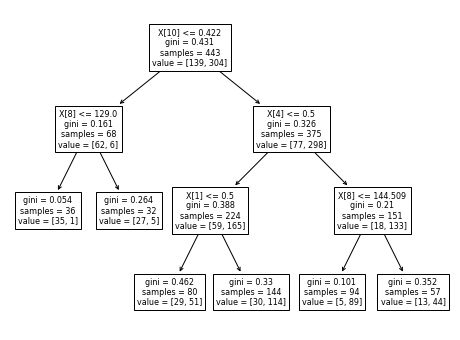

In [379]:
#Visualize the decision process using a tree
from sklearn import tree

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
tree.plot_tree(svc_model)
plt.show()

In [380]:
#We can also view the decision making process described using text
text_representation = tree.export_text(svc_model)

print(text_representation)

|--- feature_10 <= 0.42
|   |--- feature_8 <= 129.00
|   |   |--- class: 0
|   |--- feature_8 >  129.00
|   |   |--- class: 0
|--- feature_10 >  0.42
|   |--- feature_4 <= 0.50
|   |   |--- feature_1 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_1 >  0.50
|   |   |   |--- class: 1
|   |--- feature_4 >  0.50
|   |   |--- feature_8 <= 144.51
|   |   |   |--- class: 1
|   |   |--- feature_8 >  144.51
|   |   |   |--- class: 1



In [381]:
#Get some random sampled from the testing data to see the predictions
X_new = X_test.sample(5, random_state=4)
X_new

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Dependents1
612,Male,Yes,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,2
46,Male,Yes,Graduate,No,5649,0.0,44.0,360.0,1.0,Urban,1
415,Female,No,Graduate,No,2995,0.0,60.0,360.0,1.0,Urban,0
564,Male,Yes,Graduate,No,8799,0.0,258.0,360.0,0.0,Urban,2
169,Male,Yes,Graduate,No,8000,0.0,200.0,360.0,1.0,Semiurban,2


In [382]:
pipe.predict(X_new)

array([1, 1, 1, 0, 1])